# In the notebook, a model is trained for each medicine

data source: ./simplified_data/simplified_data2.csv

the last few blocks were commmented since I have no clue what they were for.




# 0. Global Variables

In [2]:
# Remove the entire column related to a specific medicine if its occurrence is below the defined threshold.
# In the given dataset, setting this threshold to 250 would retain columns for only the top 10 most frequently used medicines.
DeleteMedThreshold = 250

# Determine the number of medicines to be trained as output
# The total number of medicine is 102
NumMedTrain =102

# Decide whether to enhance accuracy by utilizing class weights
UseClassWeight = False

# Decide learning_rate
LearningRate = 0.005

# 1. Import module


In [3]:

# Importing necessary libraries
import numpy as np
import pandas as pd
import statistics
from tabulate import tabulate
import matplotlib.pyplot as plt

# Importing TensorFlow for deep learning
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.callbacks import EarlyStopping, LambdaCallback
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Importing scikit-learn for data preprocessing and utilities
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight

# Importing custom utility functions
from utility_file import my_utilities as myutil
from utility_file import load_data

# 2. Read Data
Load the data using the custom module "load_data"

In [4]:
# Load data for training a model with one specific medicine, including debugging information
(X_np, X_val_np, train_y, val_y, 
 num_col_x, num_1_valy, num_0_valy) = load_data.load_data_for_1_med_with_debug(del_med_thres=DeleteMedThreshold, 
                                                                               random_seed=3, 
                                                                               n=NumMedTrain, 
                                                                               file_name='simplified_data/data_v2_grouped_symptom.csv')

# Ensure the correct data types for loaded variables
assert isinstance(X_np, np.ndarray)
assert isinstance(X_val_np, np.ndarray)
assert isinstance(train_y, pd.DataFrame)
assert isinstance(val_y, pd.DataFrame)
assert isinstance(num_col_x, int)


--------------------------------------------------------------------------------
ReadData:
Type of data: <class 'pandas.core.frame.DataFrame'>
Shape of data = (674 rows, 150 cols).
End of ReadData
--------------------------------------------------------------------------------
SplitXY:
Shape of X = (673 rows, 46 cols).
Shape of y = (673 rows, 102 cols).
End of SplitXY
--------------------------------------------------------------------------------
In load_data_for_1_med_with_debug of load_data.py, random_seed= 3
After SplitXY, total number of 0, 1 in y:
Number of 0s: 59895
Number of 1s: 8751
--------------------------------------------------------------------------------
DeleteMedicine: shape of y is (673, 10).
save med num done
Train_X.shape:  (539, 46)
Train_y.shape:  (539, 10)

Split Training Validation
Number of 0s in train_y: 2684
Number of 1s train_y: 2706
Number of 0s in val_y: 658
Number of 1s val_y: 682
--------------------------------------------------------------------------

# 3. Data Type Checking

In [5]:
# Uncomment the line below to display the DataFrame content and structure
# myutil.print_df(val_y, "---- y ----")

# Uncomment the line below to print the DataFrame directly
# print(val_y)

# Checking:

# Counting NA values in y
na_count = val_y.isna().sum().sum()

# Counting str values in y
str_count = val_y[val_y.map(type) == str].count().sum()

# Counting int values in y
int_count = val_y[val_y.map(type) == int].count().sum()

# Counting float values in y
float_count = val_y[val_y.map(type) == float].count().sum()

# Display the results
print(f"Number of NA values in y: {na_count}")
print(f"Number of str values in y: {str_count}")
print(f"Number of int values in y: {int_count}")
print(f"Number of float values in y: {float_count}")


Number of NA values in y: 0
Number of str values in y: 0
Number of int values in y: 1340
Number of float values in y: 0


# 4. Compute Class Weight

In [6]:
# Convert the 'train_y' DataFrame to a NumPy array
train_y_np = np.array(train_y)

# Determine the number of labels (columns) in the array
num_labels = train_y_np.shape[1]

# Initialize an empty dictionary to store class weights for each label
class_weight_dic = {}

# Iterate over each label column
for i in range(num_labels):
    # Count the occurrences of each class (0 and 1) in the current label column
    unique_values, counts = np.unique(train_y_np[:, i], return_counts=True)
    
    # Create a dictionary mapping class values to their frequencies
    value_frequency_dict = dict(zip(unique_values, counts))
    
    # Calculate the total number of occurrences for normalization
    total = value_frequency_dict.get(0, 0) + value_frequency_dict.get(1, 0)
    
    # Calculate class weights and store them in the dictionary
    class_weight_dic[i] = {0: (value_frequency_dict.get(1, 0) / total), 1: (value_frequency_dict.get(0, 0) / total)}

# Display the computed class weights
print(class_weight_dic)

{0: {0: 0.49165120593692024, 1: 0.5083487940630798}, 1: {0: 0.3914656771799629, 1: 0.608534322820037}, 2: {0: 0.4749536178107607, 1: 0.5250463821892394}, 3: {0: 0.38961038961038963, 1: 0.6103896103896104}, 4: {0: 0.44155844155844154, 1: 0.5584415584415584}, 5: {0: 0.4935064935064935, 1: 0.5064935064935064}, 6: {0: 0.6549165120593692, 1: 0.3450834879406308}, 7: {0: 0.3747680890538033, 1: 0.6252319109461967}, 8: {0: 0.6326530612244898, 1: 0.3673469387755102}, 9: {0: 0.6753246753246753, 1: 0.3246753246753247}}


# 5. Build Model

In [7]:
# Define a Sequential model
model = Sequential([
    Dense(units=32, input_shape=(num_col_x,), activation='sigmoid'),
    # Additional layers (commented out for simplicity)
    # Dense(units=64, activation='relu'), 
    # Dense(units=128, activation='relu'), 
    # Dense(units=32, activation='relu'),
    # Dense(units=16, activation='sigmoid'), 
    Dense(units=2, activation='softmax')
])

# Display a summary of the model architecture
model.summary()

# Compile the model with specified optimizer, loss function, and metrics
model.compile(optimizer=Adam(learning_rate=LearningRate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1504      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________


# 6. Train Model
There will be a model for each medicine

Processing medicine 1 of 10: 桂枝
Training stopped at epoch 773
5/5 [==============================] - 0s 4ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 26690 (\N{CJK UNIFIED IDEOGRAPH-6842}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 26525 (\N{CJK UNIFIED IDEOGRAPH-679D}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 2 of 10: 柴胡
Training stopped at epoch 522
5/5 [==============================] - 0s 5ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 26612 (\N{CJK UNIFIED IDEOGRAPH-67F4}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 32993 (\N{CJK UNIFIED IDEOGRAPH-80E1}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 3 of 10: 黃芩
Training stopped at epoch 320
5/5 [==============================] - 0s 4ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 40643 (\N{CJK UNIFIED IDEOGRAPH-9EC3}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 33449 (\N{CJK UNIFIED IDEOGRAPH-82A9}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 4 of 10: 茯苓
Training stopped at epoch 544
5/5 [==============================] - 0s 3ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 33583 (\N{CJK UNIFIED IDEOGRAPH-832F}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 33491 (\N{CJK UNIFIED IDEOGRAPH-82D3}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 5 of 10: 澤瀉
Training stopped at epoch 226
5/5 [==============================] - 0s 3ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 28580 (\N{CJK UNIFIED IDEOGRAPH-6FA4}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 28681 (\N{CJK UNIFIED IDEOGRAPH-7009}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 6 of 10: 附子
Training stopped at epoch 315
5/5 [==============================] - 0s 3ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 38468 (\N{CJK UNIFIED IDEOGRAPH-9644}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 7 of 10: 甘草
Training stopped at epoch 413
5/5 [==============================] - 0s 3ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 29976 (\N{CJK UNIFIED IDEOGRAPH-7518}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 8 of 10: 當歸
Training stopped at epoch 281
5/5 [==============================] - 0s 3ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 30070 (\N{CJK UNIFIED IDEOGRAPH-7576}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 27512 (\N{CJK UNIFIED IDEOGRAPH-6B78}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 9 of 10: 白芍
Training stopped at epoch 327
5/5 [==============================] - 0s 4ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from current font.
  plt.savefig(figure_save_path)
C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 33421 (\N{CJK UNIFIED IDEOGRAPH-828D}) missing from current font.
  plt.savefig(figure_save_path)


Processing medicine 10 of 10: 炙甘草
Training stopped at epoch 281
5/5 [==============================] - 0s 5ms/step


C:\Users\taliah\AppData\Local\Temp\ipykernel_21040\1304130900.py:64: UserWarning: Glyph 28825 (\N{CJK UNIFIED IDEOGRAPH-7099}) missing from current font.
  plt.savefig(figure_save_path)


Training done.


C:\Users\taliah\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28825 (\N{CJK UNIFIED IDEOGRAPH-7099}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\taliah\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29976 (\N{CJK UNIFIED IDEOGRAPH-7518}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\taliah\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


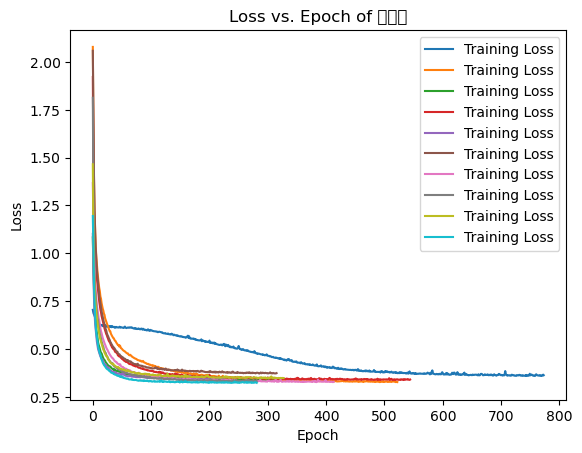

In [8]:

# Initialize dictionaries to store results and training history
result_df_dict = {}        # Dictionary of DataFrames of each medicine in training set 
accuracy_dict = {}         # Dictionary of accuracy for each medicine
prediction_train_dict = {}  # Dictionary of raw predictions for the training set
prediction_val_dict = {}    # Dictionary of raw predictions for the validation set

# Iterate over each medicine
for i in range(train_y.shape[1]):
    chosen_col = train_y.iloc[:, i].copy()
    
    # Ensure that the chosen column is a pandas Series
    assert(isinstance(chosen_col, pd.Series))
    assert(len(chosen_col) == len(train_y))
    
    print(f"Processing medicine {i + 1} of {train_y.shape[1]}: {chosen_col.name}")

    # Convert the chosen column to NumPy array
    chosen_y_np = chosen_col.values.astype('float64')

    # Copy the corresponding validation set column
    y_val_chosen_col = val_y.iloc[:, i].copy()
    
    # Ensure that the validation set column is a pandas Series
    assert(isinstance(y_val_chosen_col, pd.Series))
    assert(len(y_val_chosen_col) == len(val_y))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

    # Fit the model for the current medicine
    Model = model.fit(
        x=X_np,
        y=chosen_y_np,
        class_weight=class_weight_dic[i] if UseClassWeight else None,
        epochs=5000,
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Print when training stopped
    print(f"Training stopped at epoch {Model.epoch[-1]}")
    
    # Predict against the training set for diagnosing overfitting or underfitting
    predictions_train_set = model.predict(X_np)
    
    # Save raw result numpy array of training set to the dictionary
    prediction_train_dict[chosen_col.name] = predictions_train_set
    
    # Make predictions for the validation set
    predictions_val_set = model.predict(X_val_np)
    
    # Save raw result numpy array of validation set to the dictionary
    prediction_val_dict[chosen_col.name] = predictions_val_set
    
    # Plotting loss vs. epoch
    plt.plot(Model.history['loss'], label='Training Loss')
    plt.title(f'Loss vs. Epoch of {chosen_col.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.show()
    figure_save_path = myutil.get_figure_save_path(f"{chosen_col.name}_epoch_loss")
    plt.savefig(figure_save_path)

print("Training done.")


# 7. Handle result

### 7.1 Calculate the f1 score of the training dataset and store the values in TrainMedicineDictioanry

In [9]:
# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for the training set
total_tp_train = 0
total_fp_train = 0
total_tn_train = 0
total_fn_train = 0

# Create a dictioanry to store all values of a medicine
TrainMedicineDictioanry = {}

# Iterate through each medicine's raw prediction array
for key, arr in prediction_train_dict.items():
    
    # Create a DataFrame from the raw prediction array
    df_tmp = pd.DataFrame(arr, columns=["predicted as 0", "predicted as 1"])

    # Determine the predicted value based on probabilities
    df_tmp["predicted value"] = np.where(df_tmp["predicted as 0"] > df_tmp["predicted as 1"], 0, 1)
    
    # Get the column number of the current medicine in the training labels
    col_num = train_y.columns.get_loc(key)
    
    # Add ground truth values to the DataFrame
    df_tmp["ground truth"] = train_y.iloc[:, col_num].copy().values
    
    
    TP = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 1)).sum()
    FP = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 1)).sum()
    FN = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 0)).sum()
    TN = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 0)).sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate TP, FP, FN, TN for the current medicine
    total_tp_train += TP
    total_fp_train += FP
    total_fn_train += FN
    total_tn_train += TN
    
    TrainMedicineDictioanry[key] = {
        "TP" : TP,
        "FP" : FP,
        "FN" : FN,
        "TN" : TN,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : f1score
    }

precision = total_tp_train / (total_tp_train + total_fp_train)
recall = total_tp_train / (total_tp_train + total_fn_train)

TrainMedicineDictioanry["overall"] = {
        "TP" : total_tp_train,
        "FP" : total_fp_train,
        "FN" : total_fn_train,
        "TN" : total_tn_train,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
}

print("TrainMedicineDictioanry:")
for key in TrainMedicineDictioanry:
    print(key, TrainMedicineDictioanry[key])

TrainMedicineDictioanry:
桂枝 {'TP': 183, 'FP': 32, 'FN': 82, 'TN': 242, 'precision': 0.8511627906976744, 'recall': 0.690566037735849, 'f1-score': 0.7625}
柴胡 {'TP': 131, 'FP': 13, 'FN': 80, 'TN': 315, 'precision': 0.9097222222222222, 'recall': 0.6208530805687204, 'f1-score': 0.7380281690140844}
黃芩 {'TP': 164, 'FP': 13, 'FN': 92, 'TN': 270, 'precision': 0.9265536723163842, 'recall': 0.640625, 'f1-score': 0.7575057736720555}
茯苓 {'TP': 121, 'FP': 15, 'FN': 89, 'TN': 314, 'precision': 0.8897058823529411, 'recall': 0.5761904761904761, 'f1-score': 0.6994219653179191}
澤瀉 {'TP': 137, 'FP': 6, 'FN': 101, 'TN': 295, 'precision': 0.958041958041958, 'recall': 0.5756302521008403, 'f1-score': 0.7191601049868765}
附子 {'TP': 184, 'FP': 35, 'FN': 82, 'TN': 238, 'precision': 0.8401826484018264, 'recall': 0.6917293233082706, 'f1-score': 0.7587628865979381}
甘草 {'TP': 342, 'FP': 85, 'FN': 11, 'TN': 101, 'precision': 0.8009367681498829, 'recall': 0.9688385269121813, 'f1-score': 0.8769230769230769}
當歸 {'TP': 13

### 7.2 Calculate the f1 score of the validation dataset and store the values in ValMedicineDictioanry

In [10]:
# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for the training set
total_tp_train = 0
total_fp_train = 0
total_tn_train = 0
total_fn_train = 0

# Create a dictioanry to store all values of a medicine
ValMedicineDictioanry = {}

# Iterate through each medicine's raw prediction array
for key, arr in prediction_val_dict.items():
    
    # Create a DataFrame from the raw prediction array
    df_tmp = pd.DataFrame(arr, columns=["predicted as 0", "predicted as 1"])

    # Determine the predicted value based on probabilities
    df_tmp["predicted value"] = np.where(df_tmp["predicted as 0"] > df_tmp["predicted as 1"], 0, 1)
    
    # Get the column number of the current medicine in the training labels
    col_num = val_y.columns.get_loc(key)
    
    # Add ground truth values to the DataFrame
    df_tmp["ground truth"] = val_y.iloc[:, col_num].copy().values
    result_df_dict[key] = df_tmp
    
    TP = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 1)).sum()
    FP = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 1)).sum()
    FN = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 0)).sum()
    TN = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 0)).sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate TP, FP, FN, TN for the current medicine
    total_tp_train += TP
    total_fp_train += FP
    total_fn_train += FN
    total_tn_train += TN
    
    ValMedicineDictioanry[key] = {
        "TP" : TP,
        "FP" : FP,
        "FN" : FN,
        "TN" : TN,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : f1score
    }

precision = total_tp_train / (total_tp_train + total_fp_train)
recall = total_tp_train / (total_tp_train + total_fn_train)

ValMedicineDictioanry["overall"] = {
        "TP" : total_tp_train,
        "FP" : total_fp_train,
        "FN" : total_fn_train,
        "TN" : total_tn_train,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
}

print("ValMedicineDictioanry:")
for key in ValMedicineDictioanry:
    print(key, ValMedicineDictioanry[key])

ValMedicineDictioanry:
桂枝 {'TP': 34, 'FP': 15, 'FN': 35, 'TN': 50, 'precision': 0.6938775510204082, 'recall': 0.4927536231884058, 'f1-score': 0.576271186440678}
柴胡 {'TP': 20, 'FP': 20, 'FN': 29, 'TN': 65, 'precision': 0.5, 'recall': 0.40816326530612246, 'f1-score': 0.449438202247191}
黃芩 {'TP': 22, 'FP': 22, 'FN': 37, 'TN': 53, 'precision': 0.5, 'recall': 0.3728813559322034, 'f1-score': 0.42718446601941745}
茯苓 {'TP': 21, 'FP': 18, 'FN': 38, 'TN': 57, 'precision': 0.5384615384615384, 'recall': 0.3559322033898305, 'f1-score': 0.42857142857142855}
澤瀉 {'TP': 26, 'FP': 18, 'FN': 35, 'TN': 55, 'precision': 0.5909090909090909, 'recall': 0.4262295081967213, 'f1-score': 0.49523809523809526}
附子 {'TP': 36, 'FP': 14, 'FN': 33, 'TN': 51, 'precision': 0.72, 'recall': 0.5217391304347826, 'f1-score': 0.6050420168067228}
甘草 {'TP': 78, 'FP': 34, 'FN': 12, 'TN': 10, 'precision': 0.6964285714285714, 'recall': 0.8666666666666667, 'f1-score': 0.7722772277227722}
當歸 {'TP': 19, 'FP': 14, 'FN': 37, 'TN': 64, 'p

# 8. Result Saving

Saving resulting DataFrames to csv and dictionaries to txt for later usage

In [11]:

# Path identifier for saving results in the directory
file_path = "./result/result_each_medicine_val_csv" 

# Exporting the result of each medicine in validation set to csv file
for key, df in result_df_dict.items():

    # Uncomment if you want to print the DataFrames on console
    # print(f"DataFrame for {key}:")
    # myutil.print_df(df)
    myutil.df_to_csv(df, save_path=file_path, file_prefix=key)
   



桂枝 saved to ./result/result_each_medicine_val_csv/桂枝_2.csv
柴胡 saved to ./result/result_each_medicine_val_csv/柴胡_1.csv
黃芩 saved to ./result/result_each_medicine_val_csv/黃芩_1.csv
茯苓 saved to ./result/result_each_medicine_val_csv/茯苓_1.csv
澤瀉 saved to ./result/result_each_medicine_val_csv/澤瀉_1.csv
附子 saved to ./result/result_each_medicine_val_csv/附子_1.csv
甘草 saved to ./result/result_each_medicine_val_csv/甘草_1.csv
當歸 saved to ./result/result_each_medicine_val_csv/當歸_1.csv
白芍 saved to ./result/result_each_medicine_val_csv/白芍_1.csv
炙甘草 saved to ./result/result_each_medicine_val_csv/炙甘草_1.csv


In [12]:
# Create a DataFrame to record f1 score, TP/FP/TN/FN of each medicine
all_f1_df = pd.DataFrame([(key, val['f1-score'], val['precision'], val['recall'], 
                           val['TP'], val['FP'], val['TN'], val['FN']) for key, val in ValMedicineDictioanry.items()], 
                         columns=['medicine', 'f1-score','precision', 'recall', 'TP', 'FP', 'TN', 'FN']
                        )

file_path = "./result/result_all_medicine_val"

# Exporting the DataFrame to csv file
myutil.df_to_csv(all_f1_df, save_path=file_path, file_prefix='f1_score_all_medicine_val')

f1_score_all_medicine_val saved to ./result/result_all_medicine_val/f1_score_all_medicine_val_2.csv


In [13]:

# Specification string to be printed onto the resulting txt files
# This is for recording the training specifications that produced these results
training_specification  = "model layer:  32-64-128-64-32 units, activation: relu, optimizer: Adam, learning rate: 0.001, epochs: 1000, batch_size: 32, num_med: all. del_med_under_thres: 0"

file_path="./result/one_med_ValMedicineDict"

# Exporting f1-score, TP/FP/TN/FN of the training and validation sets to text files
myutil.dict_to_txt(ValMedicineDictioanry, save_path=file_path, 
                   file_prefix="ValMedicineDict",
                   textbox=training_specification )

file_path="./result/one_med_TrainMedicineDict"
myutil.dict_to_txt(TrainMedicineDictioanry, save_path=file_path, 
                   file_prefix="TrainMedicineDict",
                   textbox="train set, "+training_specification )


ValMedicineDict saved to ./result/one_med_ValMedicineDict/ValMedicineDict_2.txt
TrainMedicineDict saved to ./result/one_med_TrainMedicineDict/TrainMedicineDict_2.txt
